#### Computation Describtion:
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import xgboost as xgb

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [4]:
def algo_test(x,y):
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        
        algos=[L,R,Lass,E,ETR,GBR,kn,dt,xgb]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','Extra Tree','Gradient Boosting','KNeighborsRegressor','Decision Tree','XGBRegressor']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
        
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission =  pd.read_csv('sampleSubmission.csv')

## EDA
### Data exploration
### Data Visualization
Examining the dataset to understand its structure, size, and the types of variables it contains.

<AxesSubplot:>

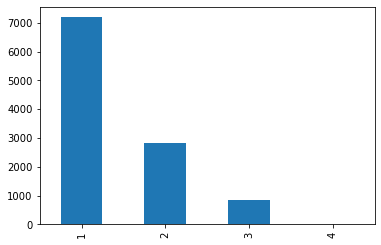

In [7]:
train.weather.value_counts().sort_values(ascending=False).plot.bar()

### Data preprocessing
###### Transforming the data to make it suitable for modeling. This can include normalizing, scaling, or encoding categorical variables.

In [8]:
train = train[train['weather'] != 4]

In [9]:
all_data = pd.concat([train, test], ignore_index = True)
all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [10]:
all_data['datetime'] = pd.to_datetime(all_data['datetime']) #type casting
all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['hour'] = all_data['datetime'].dt.hour
all_data['weekday'] = all_data['datetime'].dt.weekday
all_data = all_data.drop(['datetime', 'casual', 'registered', 'windspeed', 'month'], axis = 1)

In [11]:
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

In [12]:
X_train = X_train.drop(['count'], axis = 1)
X_test = X_test.drop(['count'], axis = 1)

In [13]:
X_train.shape, X_test.shape

((10885, 10), (6493, 10))

In [14]:
y = train['count']

### Data Modeling 
Creating models to make predictions or classify the data.

In [16]:
log_y = np.log(y)
algo_test(X_train, log_y)

,R_Squared,RMSE,MAE
XGBRegressor,0.949981,0.336750,0.222864
Gradient Boosting,0.918863,0.428893,0.316020
Decision Tree,0.902317,0.470595,0.298431
Extra Tree,0.899975,0.476204,0.311302
KNeighborsRegressor,0.815099,0.647453,0.471546
Ridge,0.480760,1.084981,0.847973
Linear,0.480760,1.084982,0.847976
ElasticNet,0.439902,1.126861,0.880790
Lasso,0.428033,1.138737,0.889393


In [17]:
xgbr = xgb.XGBRegressor()
predictions = xgbr.fit(X_train, log_y).predict(X_test)
predictions

array([2.3665016, 1.525786 , 1.1924043, ..., 4.601906 , 4.4447975,
       3.7625809], dtype=float32)

In [18]:
submission['count'] = np.exp(predictions)
submission.to_csv('submission.csv', index = False)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,10.660033
1,2011-01-20 01:00:00,4.598757
2,2011-01-20 02:00:00,3.294994
3,2011-01-20 03:00:00,2.389372
4,2011-01-20 04:00:00,1.673502
